In [1]:
# ──────────────────────────────────────────────────────────────
# 1. Imports
# ──────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_sample_weight

import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# ──────────────────────────────────────────────────────────────
# 2. Load the dataset (Kaggle path)
# ──────────────────────────────────────────────────────────────
csv_path = '/kaggle/input/dataset/root_cause_dataset_labeled.csv'
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nLabel distribution:")
print(df['label'].value_counts())

Dataset shape: (10000, 11)

First 5 rows:


,T_OBC,V_OBC,T_PDU,V_PDU,anomaly_obc,anomaly_pdu,delta_T_OBC,delta_V_OBC,delta_T_PDU,delta_V_PDU,label
0,25.730843,27.697266,32.189443,28.731679,0.5,0.500000,-0.457163,-0.021402,-0.185602,-0.042201,Normal
1,20.714010,27.705386,31.987828,28.840669,0.5,0.500000,0.062659,-0.097984,-0.332047,0.011812,Sensor_Drift
2,26.544148,28.109623,30.243528,28.013708,0.5,0.500000,0.226499,-0.010358,-0.155869,-0.090489,Normal
3,27.181381,28.103145,27.402195,28.595172,0.5,0.500000,0.026114,-0.014950,0.022940,-0.119254,Voltage_Fluctuation
4,25.139750,22.004129,33.800067,25.164554,1.0,0.995955,0.201938,-0.062832,-0.091956,0.036424,Voltage_Sag



Label distribution:
label
Normal                      5173
Sensor_Drift                1859
Voltage_Sag                 1015
Solar_Flare_Interference     958
Voltage_Fluctuation          424
Thermal_Instability          407
Overheating                  164
Name: count, dtype: int64


In [2]:
# ──────────────────────────────────────────────────────────────
# 3. Quick sanity checks
# ──────────────────────────────────────────────────────────────
print("\nMissing values:")
print(df.isna().sum())

# Drop rows with NaN (or impute if you prefer)
df = df.dropna().reset_index(drop=True)
print(f"After dropna → {df.shape}")


Missing values:
T_OBC          0
V_OBC          0
T_PDU          0
V_PDU          0
anomaly_obc    0
anomaly_pdu    0
delta_T_OBC    0
delta_V_OBC    0
delta_T_PDU    0
delta_V_PDU    0
label          0
dtype: int64
After dropna → (10000, 11)


In [3]:
# ──────────────────────────────────────────────────────────────
# 4. Define features & target
# ──────────────────────────────────────────────────────────────
feature_cols = [
    'T_OBC', 'V_OBC', 'T_PDU', 'V_PDU',
    'anomaly_obc', 'anomaly_pdu',
    'delta_T_OBC', 'delta_V_OBC',
    'delta_T_PDU', 'delta_V_PDU'
]

target_col = 'label'

X = df[feature_cols].copy()
y_raw = df[target_col].copy()

# ──────────────────────────────────────────────────────────────
# 5. Encode labels
# ──────────────────────────────────────────────────────────────
le = LabelEncoder()
y = le.fit_transform(y_raw)

print("\nLabel → integer mapping:")
for i, lbl in enumerate(le.classes_):
    print(f"  {i} → {lbl}")


Label → integer mapping:
  0 → Normal
  1 → Overheating
  2 → Sensor_Drift
  3 → Solar_Flare_Interference
  4 → Thermal_Instability
  5 → Voltage_Fluctuation
  6 → Voltage_Sag


In [4]:
# ──────────────────────────────────────────────────────────────
# 6. Scale numeric columns
# ──────────────────────────────────────────────────────────────
numeric_cols = [c for c in feature_cols if c not in ['anomaly_obc', 'anomaly_pdu']]
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [5]:
# ──────────────────────────────────────────────────────────────
# 7. Train / validation split (stratified)
# ──────────────────────────────────────────────────────────────
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}")

Train: 8000, Val: 2000


In [6]:
# ──────────────────────────────────────────────────────────────
# 8. Sample weights for class imbalance
# ──────────────────────────────────────────────────────────────
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [7]:
# ──────────────────────────────────────────────────────────────
# 9. XGBoost training with early stopping
# ──────────────────────────────────────────────────────────────
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
dval   = xgb.DMatrix(X_val,   label=y_val)

params = {
    'objective'        : 'multi:softprob',
    'num_class'        : len(le.classes_),
    'eval_metric'      : 'mlogloss',
    'eta'              : 0.05,
    'max_depth'        : 6,
    'subsample'        : 0.85,
    'colsample_bytree' : 0.85,
    'min_child_weight' : 1,
    'seed'             : 42,
    'tree_method'      : 'hist',
    'verbosity'        : 0
}

evals = [(dtrain, 'train'), (dval, 'valid')]

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=100
)

print(f"\nBest iteration: {bst.best_iteration}")

[0]	train-mlogloss:1.79843	valid-mlogloss:1.81642
[100]	train-mlogloss:0.06280	valid-mlogloss:0.12543
[200]	train-mlogloss:0.01519	valid-mlogloss:0.06264
[300]	train-mlogloss:0.00797	valid-mlogloss:0.05532
[400]	train-mlogloss:0.00534	valid-mlogloss:0.05417
[500]	train-mlogloss:0.00397	valid-mlogloss:0.05368
[550]	train-mlogloss:0.00353	valid-mlogloss:0.05395

Best iteration: 500


In [8]:
# ──────────────────────────────────────────────────────────────
# 10. Re-fit scikit-learn API (for easy predict_proba)
# ──────────────────────────────────────────────────────────────
model = xgb.XGBClassifier(
    n_estimators=bst.best_iteration,
    max_depth=params['max_depth'],
    learning_rate=params['eta'],
    subsample=params['subsample'],
    colsample_bytree=params['colsample_bytree'],
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

model.fit(X_train, y_train, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.85, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=-1,
              num_parallel_tree=None, objective='multi:softprob', ...)


=== Classification Report ===
                          precision    recall  f1-score   support

                  Normal     0.9903    0.9874    0.9889      1035
             Overheating     0.9697    0.9697    0.9697        33
            Sensor_Drift     0.9648    0.9570    0.9609       372
Solar_Flare_Interference     0.9492    0.9791    0.9639       191
     Thermal_Instability     0.9875    0.9753    0.9814        81
     Voltage_Fluctuation     0.9655    0.9882    0.9767        85
             Voltage_Sag     1.0000    0.9951    0.9975       203

                accuracy                         0.9810      2000
               macro avg     0.9753    0.9788    0.9770      2000
            weighted avg     0.9811    0.9810    0.9810      2000

Macro F1-score: 0.9770


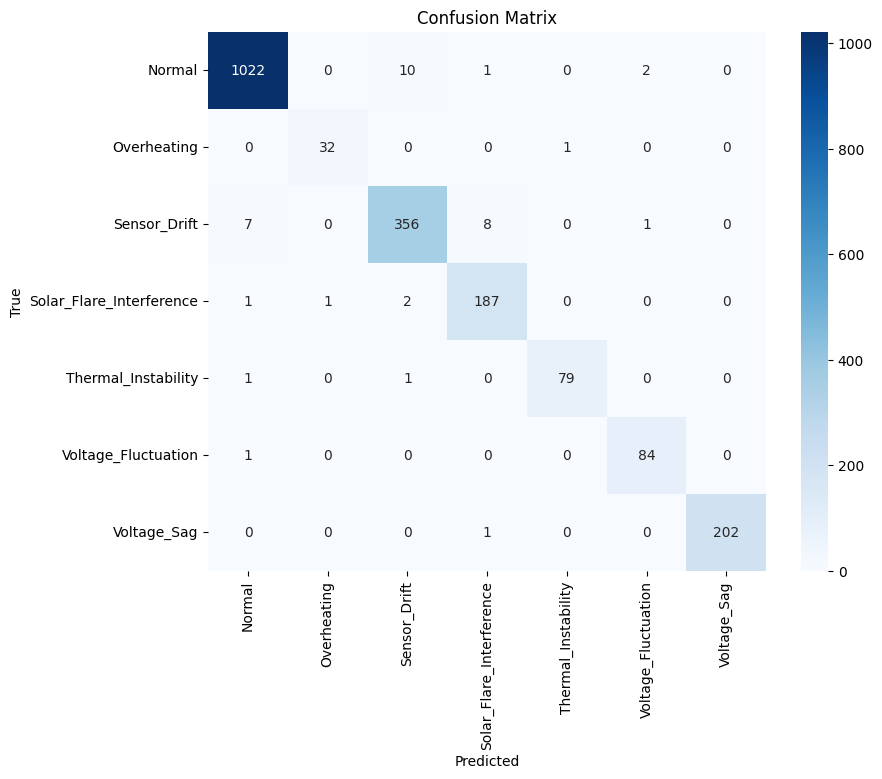

In [9]:
# ──────────────────────────────────────────────────────────────
# 11. Validation metrics
# ──────────────────────────────────────────────────────────────
y_pred = model.predict(X_val)

print("\n=== Classification Report ===")
print(classification_report(y_val, y_pred, target_names=le.classes_, digits=4))

macro_f1 = f1_score(y_val, y_pred, average='macro')
print(f"Macro F1-score: {macro_f1:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

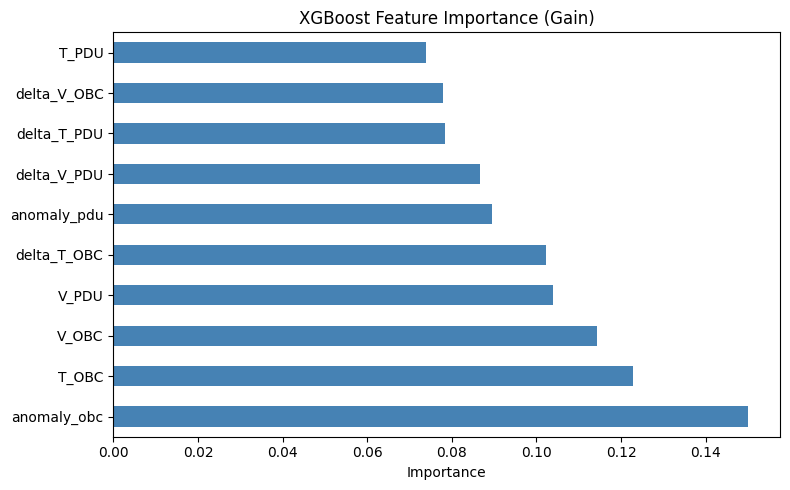

In [10]:
# ──────────────────────────────────────────────────────────────
# 12. Feature importance
# ──────────────────────────────────────────────────────────────
importances = pd.Series(model.feature_importances_, index=feature_cols)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
importances.plot(kind='barh', color='steelblue')
plt.title('XGBoost Feature Importance (Gain)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [11]:
# ──────────────────────────────────────────────────────────────
# 13. Save model + preprocessing artifacts
# ──────────────────────────────────────────────────────────────
artifacts = {
    'model'        : model,
    'scaler'       : scaler,
    'label_encoder': le,
    'features'     : feature_cols,
    'numeric_cols' : numeric_cols
}

joblib.dump(artifacts, 'satellite_xgboost_artifacts.pkl')
print("Artifacts saved → satellite_xgboost_artifacts.pkl")

Artifacts saved → satellite_xgboost_artifacts.pkl


In [12]:
# ──────────────────────────────────────────────────────────────
# 14. Inference function (copy-paste into production)
# ──────────────────────────────────────────────────────────────
def predict_new(sample_df: pd.DataFrame) -> pd.DataFrame:
    """
    Input : DataFrame with raw columns (same as training CSV)
    Output: DataFrame with predicted label + class probabilities
    """
    artifacts = joblib.load('satellite_xgboost_artifacts.pkl')
    model   = artifacts['model']
    scaler  = artifacts['scaler']
    le      = artifacts['label_encoder']
    feats   = artifacts['features']
    num_cols = artifacts['numeric_cols']

    X = sample_df[feats].copy()
    X[num_cols] = scaler.transform(X[num_cols])

    proba = model.predict_proba(X)
    pred  = model.predict(X)

    out = pd.DataFrame(proba, columns=le.classes_)
    out['predicted_label'] = le.inverse_transform(pred)
    return out

# Example:
# new_row = pd.DataFrame({ ... one row with all 11 columns ... })
# result = predict_new(new_row)
# print(result)

In [14]:
# ──────────────────────────────────────────────────────────────
# predict_manual.py  –  Manual input → XGBoost prediction
# ──────────────────────────────────────────────────────────────
import pandas as pd
import joblib
import numpy as np

# --------------------------------------------------------------
# 1. Load the trained artifacts
# --------------------------------------------------------------
ARTIFACT_PATH = 'satellite_xgboost_artifacts.pkl'   # <-- change if needed
artifacts = joblib.load(ARTIFACT_PATH)

model        = artifacts['model']
scaler       = artifacts['scaler']
le           = artifacts['label_encoder']
feature_cols = artifacts['features']
numeric_cols = artifacts['numeric_cols']

print("Model loaded. Ready for manual input.\n")

# --------------------------------------------------------------
# 2. Manual input function
# --------------------------------------------------------------
def get_manual_input():
    print("Enter values one by one (press Enter after each):")
    data = {}
    for col in feature_cols:
        while True:
            try:
                val = input(f"  {col}: ")
                # Convert to float for numeric, int for flags
                if col in ['anomaly_obc', 'anomaly_pdu']:
                    val = int(float(val))   # accept 0/1
                else:
                    val = float(val)
                data[col] = val
                break
            except ValueError:
                print("   Invalid input – please enter a number.")
    return pd.DataFrame([data])

# --------------------------------------------------------------
# 3. Prediction function
# --------------------------------------------------------------
def predict(df_raw):
    X = df_raw[feature_cols].copy()
    X[numeric_cols] = scaler.transform(X[numeric_cols])
    
    proba = model.predict_proba(X)[0]
    pred_idx = np.argmax(proba)
    pred_label = le.inverse_transform([pred_idx])[0]
    
    # Build nice output
    out = pd.DataFrame({
        'Class': le.classes_,
        'Probability': proba
    }).sort_values('Probability', ascending=False)
    out['Probability'] = out['Probability'].map('{:.1%}'.format)
    
    print("\nPREDICTION RESULT")
    print("="*50)
    print(f"Predicted → {pred_label}")
    print("="*50)
    print(out.to_string(index=False))

# --------------------------------------------------------------
# 4. Run
# --------------------------------------------------------------
if __name__ == "__main__":
    manual_df = get_manual_input()
    predict(manual_df)

Model loaded. Ready for manual input.

Enter values one by one (press Enter after each):


  T_OBC:  32
  V_OBC:  12
  T_PDU:  30
  V_PDU:  11
  anomaly_obc:  0.3
  anomaly_pdu:  0.3
  delta_T_OBC:  2
  delta_V_OBC:  1
  delta_T_PDU:  3
  delta_V_PDU:  1



PREDICTION RESULT
Predicted → Thermal_Instability
                   Class Probability
     Thermal_Instability       92.9%
             Voltage_Sag        7.1%
Solar_Flare_Interference        0.0%
                  Normal        0.0%
            Sensor_Drift        0.0%
     Voltage_Fluctuation        0.0%
             Overheating        0.0%
